# Masterclass Magistral: Clasificación de Mora (RCC) – Notebook Profesional V6
**Caso práctico:** Predicción de mora a 30 días en los próximos 3 meses.

Este notebook está diseñado para:
- **Clase magistral** (conceptos + práctica)
- **Estándar banca/producción** (anti-leakage, validación temporal, drift)

Modelos evaluados (5):
1) Regresión Logística (baseline regulatorio)
2) Random Forest
3) XGBoost (boosting)
4) LightGBM (boosting)
5) CatBoost (boosting con categóricas nativas)

Métricas clave:
- ROC-AUC
- PR-AUC
- **GINI = 2·AUC − 1**
- **KS = max(TPR − FPR)**
- **Lift Top 10%**
- **PSI** (drift de variables y drift del score)


## 0. Reglas anti-leakage (críticas en banca)
- `id_cliente` **NO** es feature (evita memorizar clientes).
- `periodo` **NO** es feature (se usa para split temporal y monitoreo).
- Split **estrictamente temporal** por `periodo`.
- Todas las transformaciones se entrenan **solo con TRAIN** y luego se aplican a TEST/OOT.


In [1]:
# ===============================
# 1) Imports y configuración
# ===============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score, average_precision_score, roc_curve, precision_recall_curve
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb
import lightgbm as lgb
from catboost import CatBoostClassifier

import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# Columnas confirmadas del dataset
ID_COL = "id_cliente"
TIME_COL = "periodo"
TARGET = "mora_30d_next3m"

from IPython.display import display

## 2. Carga de datos + validación básica

Este notebook está pensado para correr **sin copiar archivos manualmente**.

- Si `dataset_mora.csv` existe en el mismo folder, se carga desde disco.
- Si no existe, se descarga automáticamente desde el **raw URL del repo Git** (GitHub).

> Si tu repo/branch/ruta cambia, solo actualiza `DATA_URL` en la celda siguiente.


In [2]:
# ==========================================
# 2) Carga de datos (GitHub raw) + fallback local
# ==========================================
GITHUB_RAW = "https://raw.githubusercontent.com/josefrodrim/ML-course/main/data/dataset_mora.csv"
LOCAL_PATH = "data/dataset_mora.csv"  # si clonan el repo y ejecutan desde la raíz

try:
    df = pd.read_csv(GITHUB_RAW)
    print("Dataset cargado desde GitHub ")
except Exception as e:
    print("No se pudo cargar desde GitHub. Intentando local...")
    df = pd.read_csv(LOCAL_PATH)
    print("Dataset cargado desde ruta local ")

print("Shape:", df.shape)
display(df.head())

Dataset cargado desde GitHub 
Shape: (36180, 18)


,id_cliente,periodo,edad,sexo,region,segmento,ingreso_mensual,score_bureau,num_lineas,max_mora_12m,mora_30d_12m,saldo_total,utilizacion_tc,antig_laboral_anios,antig_banca_anios,producto_principal,canal_origen,mora_30d_next3m
0,C001468,202508,44,F,Lima,C,1216.74,619.0,0,0,0,2626.98,0.7406391036855144,6.0,2.2,Hipotecario,Digital,0
1,C000819,202412,28,M,Norte,A,4383.33,608.0,3,0,0,9757.52,0.613334504526248,1.6,1.1,TC,Tienda,1
2,C000739,202410,35,M,Lima,B,3560.49,611.0,3,0,1,3702.30,0.09751335927199843,4.7,1.4,Pyme,Digital,0
3,C001080,202406,26,M,Norte,B,2505.25,690.0,4,1,1,3479.64,0.1416807201234781,10.0,0.0,PL,Digital,0
4,C000736,202406,62,M,Lima,A,1866.13,717.0,2,1,0,2274.58,0.24411083948236922,8.3,2.3,Hipotecario,FuerzaVenta,0


## 3. Limpieza de tipos (dtype cleaning)
En datasets reales, algunas variables numéricas vienen como texto (por comas, % o separadores). Esto rompe LightGBM/XGBoost y distorsiona el preprocesamiento.

**Regla:** convertir a numérico con `errors='coerce'` y manejar missing con imputación en pipeline.

In [3]:
# ===============================
# 3) Limpieza de dtypes
# ===============================
df = df.copy()

# numéricas esperadas (según columnas del dataset)
num_should_be = [
    "edad", "ingreso_mensual", "score_bureau", "num_lineas", "max_mora_12m", "mora_30d_12m",
    "saldo_total", "utilizacion_tc", "antig_laboral_anios", "antig_banca_anios"
]

for c in num_should_be:
    if c in df.columns:
        df[c] = (
            df[c].astype(str)
                .str.replace(",", "", regex=False)
                .str.replace("%", "", regex=False)
                .str.strip()
        )
        df[c] = pd.to_numeric(df[c], errors="coerce")

# categóricas esperadas
cat_should_be = ["sexo", "region", "segmento", "producto_principal", "canal_origen"]
for c in cat_should_be:
    if c in df.columns:
        df[c] = df[c].astype("string")

print("Tipos (numéricas):")
display(df[num_should_be].dtypes)
print("Tipos (categóricas):")
display(df[cat_should_be].dtypes)


Tipos (numéricas):


edad                     int64
ingreso_mensual        float64
score_bureau           float64
num_lineas               int64
max_mora_12m             int64
mora_30d_12m             int64
saldo_total            float64
utilizacion_tc         float64
antig_laboral_anios    float64
antig_banca_anios      float64
dtype: object

Tipos (categóricas):


sexo                  string
region                string
segmento              string
producto_principal    string
canal_origen          string
dtype: object

## 4. Normalización temporal de `periodo`
Creamos `periodo_ord` como YYYYMM entero para ordenar, split temporal y análisis de drift. Soporta formatos `YYYYMM`, `YYYY-MM`, fechas, etc.

In [4]:
# ===============================
# 4) Normalizar 'periodo' -> periodo_ord (YYYYMM)
# ===============================
def to_period_ord(s: pd.Series) -> pd.Series:
    s_str = s.astype(str).str.replace(r"[^0-9]", "", regex=True)
    ok = s_str.str.len() == 6
    out = pd.Series(pd.NA, index=s.index, dtype="Int64")
    out.loc[ok] = s_str.loc[ok].astype("Int64")
    if out.isna().any():
        dt = pd.to_datetime(s, errors="coerce")
        out2 = (dt.dt.year * 100 + dt.dt.month).astype("Int64")
        out = out.fillna(out2)
    return out

df["periodo_ord"] = to_period_ord(df[TIME_COL])
assert df["periodo_ord"].isna().mean() == 0, "No se pudo parsear 'periodo' en algunos registros."

df = df.sort_values("periodo_ord").reset_index(drop=True)
print("Rango periodo_ord:", int(df["periodo_ord"].min()), "->", int(df["periodo_ord"].max()))


Rango periodo_ord: 202310 -> 202509


## 5. EDA mínimo (target + estabilidad temporal)
- Distribución del target
- Tasa de mora por periodo (drift del target)


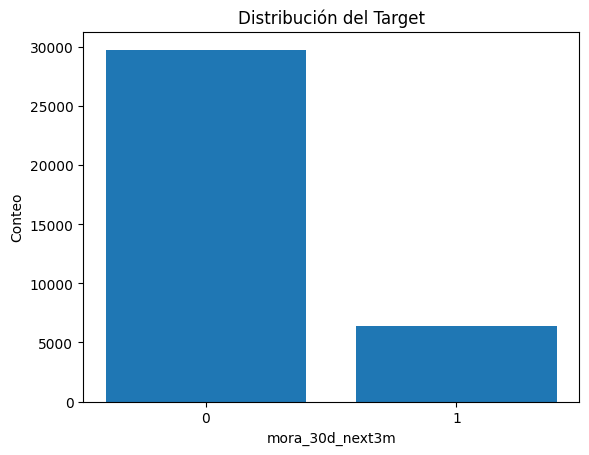

Tasa de mora global: 0.1773355444997236


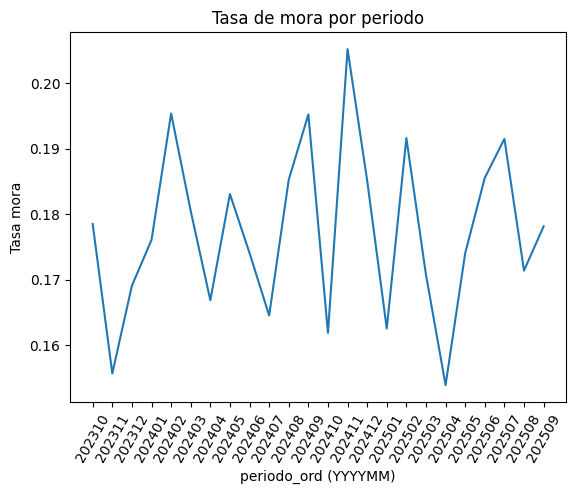

In [5]:
# ===============================
# 5) EDA: Target
# ===============================
plt.figure()
vals = df[TARGET].value_counts().sort_index()
plt.bar(vals.index.astype(str), vals.values)
plt.title("Distribución del Target")
plt.xlabel(TARGET)
plt.ylabel("Conteo")
plt.show()

print("Tasa de mora global:", float(df[TARGET].mean()))

# Tasa de mora por periodo
rate_by_period = df.groupby("periodo_ord")[TARGET].mean()
plt.figure()
plt.plot(rate_by_period.index.astype(str), rate_by_period.values)
plt.title("Tasa de mora por periodo")
plt.xlabel("periodo_ord (YYYYMM)")
plt.ylabel("Tasa mora")
plt.xticks(rotation=60)
plt.show()


## 6. Split temporal (Train / Test / OOT)
Split por **periodos únicos** para no partir un periodo entre conjuntos.

Por defecto:
- Train: 70% periodos
- Test: 15% periodos
- OOT: 15% periodos


In [6]:
# ===============================
# 6) Split temporal por periodos únicos
# ===============================
periods = sorted(df["periodo_ord"].unique())
n = len(periods)

train_periods = periods[: int(n*0.70)]
test_periods  = periods[int(n*0.70): int(n*0.85)]
oot_periods   = periods[int(n*0.85):]

train_df = df[df["periodo_ord"].isin(train_periods)].copy()
test_df  = df[df["periodo_ord"].isin(test_periods)].copy()
oot_df   = df[df["periodo_ord"].isin(oot_periods)].copy()

print("Train periods:", (min(train_periods), max(train_periods)), "n=", len(train_periods), "rows=", train_df.shape[0])
print("Test  periods:", (min(test_periods),  max(test_periods)),  "n=", len(test_periods),  "rows=", test_df.shape[0])
print("OOT   periods:", (min(oot_periods),   max(oot_periods)),   "n=", len(oot_periods),   "rows=", oot_df.shape[0])

for name, d in [("TRAIN", train_df), ("TEST", test_df), ("OOT", oot_df)]:
    print(name, "target_rate=", round(float(d[TARGET].mean()), 4), "n=", len(d))


Train periods: (np.int64(202310), np.int64(202501)) n= 16 rows= 24120
Test  periods: (np.int64(202502), np.int64(202505)) n= 4 rows= 6026
OOT   periods: (np.int64(202506), np.int64(202509)) n= 4 rows= 6034
TRAIN target_rate= 0.1774 n= 24120
TEST target_rate= 0.1726 n= 6026
OOT target_rate= 0.1816 n= 6034


## 7. Definición de features (excluyendo ID y tiempo)
Excluimos: `id_cliente`, `periodo`, `periodo_ord`, `target`.


In [7]:
# ===============================
# 7) Features (VERSIÓN DEFINITIVA ESTABLE)
# ===============================
import numpy as np
import pandas as pd

DROP_COLS = [ID_COL, TIME_COL, "periodo_ord", TARGET]
features = [c for c in df.columns if c not in DROP_COLS]

X_train = train_df[features].copy()
y_train = train_df[TARGET].astype(int).copy()

X_test  = test_df[features].copy()
y_test  = test_df[TARGET].astype(int).copy()

X_oot   = oot_df[features].copy()
y_oot   = oot_df[TARGET].astype(int).copy()

# --------------------------------------------------
# 1) Convertir TODO el dataframe a numpy backend
#    (esto elimina definitivamente pd.NA)
# --------------------------------------------------

def force_numpy_nan(df_in):
    return pd.DataFrame(
        df_in.to_numpy(dtype=object),
        columns=df_in.columns
    ).replace({pd.NA: np.nan})

X_train = force_numpy_nan(X_train)
X_test  = force_numpy_nan(X_test)
X_oot   = force_numpy_nan(X_oot)

# --------------------------------------------------
# 2) Convertir numéricas correctamente
# --------------------------------------------------

num_should_be = [
    "edad",
    "ingreso_mensual",
    "score_bureau",
    "num_lineas",
    "max_mora_12m",
    "mora_30d_12m",
    "saldo_total",
    "utilizacion_tc",
    "antig_laboral_anios",
    "antig_banca_anios",
]

for c in num_should_be:
    if c in X_train.columns:
        for X in (X_train, X_test, X_oot):
            X[c] = (
                X[c].astype(str)
                    .str.replace(",", "", regex=False)
                    .str.replace("%", "", regex=False)
                    .str.strip()
            )
            X[c] = pd.to_numeric(X[c], errors="coerce")

# --------------------------------------------------
# 3) Categóricas como object (no "string")
# --------------------------------------------------

cat_should_be = ["sexo", "region", "segmento", "producto_principal", "canal_origen"]

for c in cat_should_be:
    if c in X_train.columns:
        for X in (X_train, X_test, X_oot):
            X[c] = X[c].astype("object")

# --------------------------------------------------
# 4) Recalcular columnas numéricas y categóricas
# --------------------------------------------------

num_cols = X_train.select_dtypes(include=["int64","float64","int32","float32"]).columns.tolist()
cat_cols = [c for c in features if c not in num_cols]

print("Features:", len(features))
print("Numéricas:", len(num_cols))
print("Categóricas:", len(cat_cols))

Features: 15
Numéricas: 10
Categóricas: 5


## 8. Correlación (numéricas) + alerta leakage
Mostramos correlación de variables numéricas y su correlación con el target. Buscamos:
- multicolinealidad alta entre features
- features con correlación excesiva con el target (posible leakage)


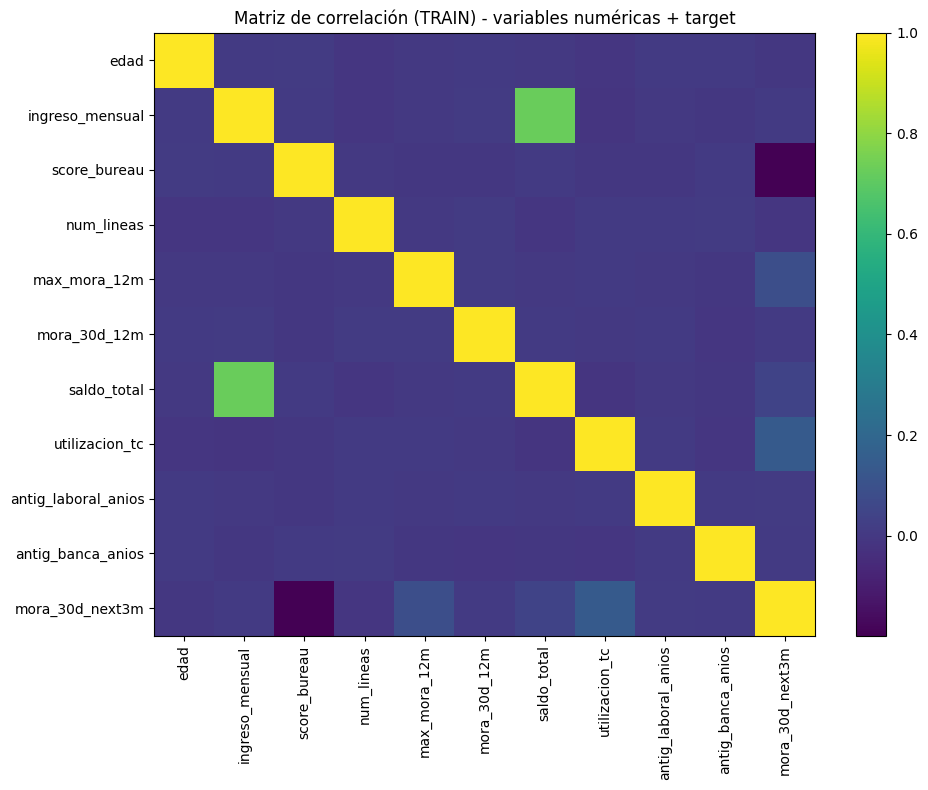

Top correlación con target (abs):


score_bureau          -0.199043
utilizacion_tc         0.141585
max_mora_12m           0.089923
saldo_total            0.042436
num_lineas            -0.010508
antig_laboral_anios    0.008077
mora_30d_12m           0.005030
edad                  -0.004997
antig_banca_anios      0.003580
ingreso_mensual        0.002502
Name: mora_30d_next3m, dtype: float64

In [8]:
# ===============================
# 8) Correlación numérica
# ===============================
num_plus_target = train_df[num_cols + [TARGET]].copy()

corr = num_plus_target.corr(numeric_only=True)

plt.figure(figsize=(10, 8))
plt.imshow(corr.values, aspect="auto")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.title("Matriz de correlación (TRAIN) - variables numéricas + target")
plt.tight_layout()
plt.show()

corr_target = corr[TARGET].drop(TARGET).sort_values(ascending=False)
print("Top correlación con target (abs):")
display(corr_target.reindex(corr_target.abs().sort_values(ascending=False).index).head(10))


## 9. Preprocesamiento
Para LR/RF/LGBM: imputación + OneHotEncoder para categóricas. 
- LR: escalamos numéricas
- Árboles: no escalamos numéricas

**Nota:** para CatBoost no usamos OHE; usa categóricas nativas.


In [9]:
# ===============================
# 9) Preprocesamiento (OHE)
# ===============================
num_pipe_no_scale = Pipeline([
    ("imputer", SimpleImputer(strategy="median", missing_values=np.nan)),
])

num_pipe_scale = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

cat_pipe = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent", missing_values=np.nan)),
    ("ohe", OneHotEncoder(handle_unknown="ignore"))
])

preprocess_lr = ColumnTransformer([
    ("num", num_pipe_scale, num_cols),
    ("cat", cat_pipe, cat_cols)
])

preprocess_tree = ColumnTransformer([
    ("num", num_pipe_no_scale, num_cols),
    ("cat", cat_pipe, cat_cols)
])


## 10. Métricas (definiciones)
- **ROC-AUC:** capacidad de ranking global.
- **PR-AUC:** recomendado en desbalance.
- **GINI:** estándar banca: `GINI = 2*AUC - 1`.
- **KS:** separación máxima entre distribuciones de score de buenos/malos.
- **Lift Top 10%:** concentración de eventos en el decil superior.


In [10]:
# ===============================
# 10) Métricas
# ===============================
def gini_from_auc(auc): 
    return 2*auc - 1

def ks_statistic(y_true, y_prob):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return float(np.max(tpr - fpr))

def lift_top_decile(y_true, y_prob):
    tmp = pd.DataFrame({"y": y_true, "p": y_prob}).sort_values("p", ascending=False)
    k = max(1, int(len(tmp)*0.10))
    return float(tmp.head(k)["y"].mean() / tmp["y"].mean())

def metrics_pack(y_true, y_prob):
    auc = roc_auc_score(y_true, y_prob)
    return {
        "AUC": float(auc),
        "GINI": float(gini_from_auc(auc)),
        "PR_AUC": float(average_precision_score(y_true, y_prob)),
        "KS": float(ks_statistic(y_true, y_prob)),
        "LIFT_10": float(lift_top_decile(y_true, y_prob)),
    }


## 11. PSI (Population Stability Index)
Mide drift entre dos distribuciones.

Interpretación típica:
- PSI < 0.10: estable
- 0.10–0.25: drift moderado
- > 0.25: drift fuerte

Calcularemos:
- PSI por variable numérica (TRAIN vs OOT)
- PSI del score (TRAIN vs OOT)


In [11]:
# ===============================
# 11) PSI
# ===============================
def psi_numeric(expected: np.ndarray, actual: np.ndarray, buckets: int = 10) -> float:
    expected = np.asarray(expected)
    actual = np.asarray(actual)
    expected = expected[~np.isnan(expected)]
    actual = actual[~np.isnan(actual)]
    if len(expected) == 0 or len(actual) == 0:
        return np.nan

    breakpoints = np.percentile(expected, np.linspace(0, 100, buckets + 1))
    breakpoints = np.unique(breakpoints)
    if len(breakpoints) <= 2:
        return 0.0

    e_cnt, _ = np.histogram(expected, bins=breakpoints)
    a_cnt, _ = np.histogram(actual, bins=breakpoints)

    e_perc = e_cnt / max(e_cnt.sum(), 1)
    a_perc = a_cnt / max(a_cnt.sum(), 1)

    eps = 1e-6
    return float(np.sum((a_perc - e_perc) * np.log((a_perc + eps) / (e_perc + eps))))

# PSI por variable numérica (TRAIN vs OOT)
psi_rows = []
for c in num_cols:
    psi_val = psi_numeric(train_df[c].values, oot_df[c].values, buckets=10)
    psi_rows.append((c, psi_val))
psi_df = pd.DataFrame(psi_rows, columns=["feature", "psi_train_vs_oot"]).sort_values("psi_train_vs_oot", ascending=False)
display(psi_df.head(15))


,feature,psi_train_vs_oot
1,ingreso_mensual,0.011813
6,saldo_total,0.007488
2,score_bureau,0.004075
9,antig_banca_anios,0.002952
8,antig_laboral_anios,0.002802
0,edad,0.002264
7,utilizacion_tc,0.001555
3,num_lineas,0.000432
4,max_mora_12m,0.000313
5,mora_30d_12m,0.000000


## 12. Modelamiento
Manejo de desbalance:
- LR/RF: `class_weight='balanced'`
- XGB/LGBM: `scale_pos_weight = #neg / #pos` (en TRAIN)
- CatBoost: `class_weights=[w_neg, w_pos]`


In [12]:
# ===============================
# 12) scale_pos_weight (TRAIN)
# ===============================
pos = int(y_train.sum())
neg = int(len(y_train) - pos)
scale_pos_weight = float(neg / max(pos, 1))
print("Pos:", pos, "Neg:", neg, "scale_pos_weight:", round(scale_pos_weight, 4))


Pos: 4280 Neg: 19840 scale_pos_weight: 4.6355


### 12.1 Logistic Regression (pipeline)
Baseline regulatorio: interpretabilidad alta, performance razonable si features están bien.

In [13]:
log_model = Pipeline([
    ("prep", preprocess_lr),
    ("clf", LogisticRegression(
        max_iter=3000,
        class_weight="balanced",
        solver="lbfgs",
        random_state=RANDOM_STATE
    ))
])


### 12.2 Random Forest (pipeline)
Modelo estable (bagging) pero a veces menor poder que boosting.

In [14]:
rf_model = Pipeline([
    ("prep", preprocess_tree),
    ("clf", RandomForestClassifier(
        n_estimators=600,
        max_depth=10,
        min_samples_leaf=50,
        class_weight="balanced",
        n_jobs=-1,
        random_state=RANDOM_STATE
    ))
])


In [15]:
print(X_train.dtypes)
print("pd.NA count:", X_train.isna().sum().sum())

edad                     int64
sexo                    object
region                  object
segmento                object
ingreso_mensual        float64
score_bureau           float64
num_lineas               int64
max_mora_12m             int64
mora_30d_12m             int64
saldo_total            float64
utilizacion_tc         float64
antig_laboral_anios    float64
antig_banca_anios      float64
producto_principal      object
canal_origen            object
dtype: object
pd.NA count: 3758


### 12.3 XGBoost PRO (early stopping) – robusto a versiones
Usamos `xgb.train()` con `DMatrix`, que suele soportar `early_stopping_rounds` incluso en versiones antiguas.

In [16]:
# Preprocesamos con OHE para XGB
X_tr_xgb = preprocess_tree.fit_transform(X_train)
X_te_xgb = preprocess_tree.transform(X_test)
X_oo_xgb = preprocess_tree.transform(X_oot)

dtrain = xgb.DMatrix(X_tr_xgb, label=y_train)
dtest  = xgb.DMatrix(X_te_xgb, label=y_test)
doot   = xgb.DMatrix(X_oo_xgb, label=y_oot)

xgb_params = {
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "eta": 0.03,
    "max_depth": 5,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "min_child_weight": 5,
    "lambda": 2.0,
    "scale_pos_weight": scale_pos_weight,
    "seed": RANDOM_STATE,
}

watchlist = [(dtrain, "train"), (dtest, "test")]

xgb_bst = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=5000,
    evals=watchlist,
    early_stopping_rounds=100,
    verbose_eval=False
)


### 12.4 LightGBM robusto
Entrenamos sobre matriz ya transformada (OHE), evitando problemas de dtypes.

In [17]:
# Preprocesamos con OHE para LGBM
X_tr_lgb = preprocess_tree.fit_transform(X_train)
X_te_lgb = preprocess_tree.transform(X_test)
X_oo_lgb = preprocess_tree.transform(X_oot)

lgb_clf = lgb.LGBMClassifier(
    n_estimators=5000,
    learning_rate=0.03,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=2.0,
    min_child_samples=100,
    scale_pos_weight=scale_pos_weight,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

# Algunas versiones aceptan early_stopping_rounds; otras no.
# Intentamos de forma segura.
try:
    lgb_clf.fit(
        X_tr_lgb, y_train,
        eval_set=[(X_te_lgb, y_test)],
        eval_metric="auc",
        early_stopping_rounds=100,
        verbose=False
    )
except TypeError:
    lgb_clf.fit(
        X_tr_lgb, y_train,
        eval_set=[(X_te_lgb, y_test)],
        eval_metric="auc"
    )


[LightGBM] [Info] Number of positive: 4280, number of negative: 19840
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000578 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1389
[LightGBM] [Info] Number of data points in the train set: 24120, number of used features: 32
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.177446 -> initscore=-1.533747
[LightGBM] [Info] Start training from score -1.533747


### 12.5 CatBoost (categóricas nativas)
CatBoost suele funcionar muy bien en datasets con categóricas reales (segmento, producto, canal, región).

In [18]:
# Imputación simple para CatBoost (sin OHE)
X_train_cb = X_train.copy()
X_test_cb  = X_test.copy()
X_oot_cb   = X_oot.copy()

# numéricas
for c in num_cols:
    med = X_train_cb[c].median()
    X_train_cb[c] = X_train_cb[c].fillna(med)
    X_test_cb[c]  = X_test_cb[c].fillna(med)
    X_oot_cb[c]   = X_oot_cb[c].fillna(med)

# categóricas (string)
for c in cat_cols:
    mode = X_train_cb[c].mode(dropna=True)
    fill = mode.iloc[0] if len(mode) else "MISSING"
    X_train_cb[c] = X_train_cb[c].fillna(fill).astype(str)
    X_test_cb[c]  = X_test_cb[c].fillna(fill).astype(str)
    X_oot_cb[c]   = X_oot_cb[c].fillna(fill).astype(str)

cat_features_idx = [X_train_cb.columns.get_loc(c) for c in cat_cols]

w_neg = 1.0
w_pos = scale_pos_weight

cat_clf = CatBoostClassifier(
    iterations=5000,
    learning_rate=0.03,
    depth=6,
    l2_leaf_reg=6,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=0,
    class_weights=[w_neg, w_pos]
)

cat_clf.fit(
    X_train_cb, y_train,
    cat_features=cat_features_idx,
    eval_set=(X_test_cb, y_test),
    use_best_model=True,
    verbose=False
)


CatBoostClassifier(class_weights=[1.0, 4.635514018691588], depth=6, eval_metric='AUC', iterations=5000, l2_leaf_reg=6, learning_rate=0.03, loss_function='Logloss', random_seed=42, verbose=0)

## 13. Evaluación unificada + tabla comparativa
Reportamos Train/Test/OOT + gaps para detectar overfitting y drift.


In [19]:
def eval_pipeline(name, model):
    model.fit(X_train, y_train)
    p_tr  = model.predict_proba(X_train)[:, 1]
    p_te  = model.predict_proba(X_test)[:, 1]
    p_oo  = model.predict_proba(X_oot)[:, 1]
    return p_tr, p_te, p_oo

results = []
preds_map = {}

# Logistic
p_tr, p_te, p_oo = eval_pipeline("Logistic", log_model)
preds_map["Logistic"] = {"p_train": p_tr, "p_test": p_te, "p_oot": p_oo}

m_tr, m_te, m_oo = metrics_pack(y_train, p_tr), metrics_pack(y_test, p_te), metrics_pack(y_oot, p_oo)
results.append({
    "Model":"Logistic",
    "Train_AUC": m_tr["AUC"], "Test_AUC": m_te["AUC"], "OOT_AUC": m_oo["AUC"],
    "OOT_GINI": m_oo["GINI"], "OOT_KS": m_oo["KS"], "OOT_LIFT10": m_oo["LIFT_10"], "OOT_PR_AUC": m_oo["PR_AUC"],
    "Gap_Train_Test_AUC": m_tr["AUC"] - m_te["AUC"],
    "Gap_Test_OOT_AUC": m_te["AUC"] - m_oo["AUC"],
})

# RandomForest
p_tr, p_te, p_oo = eval_pipeline("RandomForest", rf_model)
preds_map["RandomForest"] = {"p_train": p_tr, "p_test": p_te, "p_oot": p_oo}

m_tr, m_te, m_oo = metrics_pack(y_train, p_tr), metrics_pack(y_test, p_te), metrics_pack(y_oot, p_oo)
results.append({
    "Model":"RandomForest",
    "Train_AUC": m_tr["AUC"], "Test_AUC": m_te["AUC"], "OOT_AUC": m_oo["AUC"],
    "OOT_GINI": m_oo["GINI"], "OOT_KS": m_oo["KS"], "OOT_LIFT10": m_oo["LIFT_10"], "OOT_PR_AUC": m_oo["PR_AUC"],
    "Gap_Train_Test_AUC": m_tr["AUC"] - m_te["AUC"],
    "Gap_Test_OOT_AUC": m_te["AUC"] - m_oo["AUC"],
})

# XGBoost (xgb.train)
p_tr = xgb_bst.predict(dtrain)
p_te = xgb_bst.predict(dtest)
p_oo = xgb_bst.predict(doot)
preds_map["XGBoost"] = {"p_train": p_tr, "p_test": p_te, "p_oot": p_oo}

m_tr, m_te, m_oo = metrics_pack(y_train, p_tr), metrics_pack(y_test, p_te), metrics_pack(y_oot, p_oo)
results.append({
    "Model":"XGBoost",
    "Train_AUC": m_tr["AUC"], "Test_AUC": m_te["AUC"], "OOT_AUC": m_oo["AUC"],
    "OOT_GINI": m_oo["GINI"], "OOT_KS": m_oo["KS"], "OOT_LIFT10": m_oo["LIFT_10"], "OOT_PR_AUC": m_oo["PR_AUC"],
    "Gap_Train_Test_AUC": m_tr["AUC"] - m_te["AUC"],
    "Gap_Test_OOT_AUC": m_te["AUC"] - m_oo["AUC"],
})

# LightGBM
p_tr = lgb_clf.predict_proba(X_tr_lgb)[:, 1]
p_te = lgb_clf.predict_proba(X_te_lgb)[:, 1]
p_oo = lgb_clf.predict_proba(X_oo_lgb)[:, 1]
preds_map["LightGBM"] = {"p_train": p_tr, "p_test": p_te, "p_oot": p_oo}

m_tr, m_te, m_oo = metrics_pack(y_train, p_tr), metrics_pack(y_test, p_te), metrics_pack(y_oot, p_oo)
results.append({
    "Model":"LightGBM",
    "Train_AUC": m_tr["AUC"], "Test_AUC": m_te["AUC"], "OOT_AUC": m_oo["AUC"],
    "OOT_GINI": m_oo["GINI"], "OOT_KS": m_oo["KS"], "OOT_LIFT10": m_oo["LIFT_10"], "OOT_PR_AUC": m_oo["PR_AUC"],
    "Gap_Train_Test_AUC": m_tr["AUC"] - m_te["AUC"],
    "Gap_Test_OOT_AUC": m_te["AUC"] - m_oo["AUC"],
})

# CatBoost
p_tr = cat_clf.predict_proba(X_train_cb)[:, 1]
p_te = cat_clf.predict_proba(X_test_cb)[:, 1]
p_oo = cat_clf.predict_proba(X_oot_cb)[:, 1]
preds_map["CatBoost"] = {"p_train": p_tr, "p_test": p_te, "p_oot": p_oo}

m_tr, m_te, m_oo = metrics_pack(y_train, p_tr), metrics_pack(y_test, p_te), metrics_pack(y_oot, p_oo)
results.append({
    "Model":"CatBoost",
    "Train_AUC": m_tr["AUC"], "Test_AUC": m_te["AUC"], "OOT_AUC": m_oo["AUC"],
    "OOT_GINI": m_oo["GINI"], "OOT_KS": m_oo["KS"], "OOT_LIFT10": m_oo["LIFT_10"], "OOT_PR_AUC": m_oo["PR_AUC"],
    "Gap_Train_Test_AUC": m_tr["AUC"] - m_te["AUC"],
    "Gap_Test_OOT_AUC": m_te["AUC"] - m_oo["AUC"],
})

results_df = pd.DataFrame(results).sort_values("OOT_GINI", ascending=False).reset_index(drop=True)
display(results_df)


,Model,Train_AUC,Test_AUC,OOT_AUC,OOT_GINI,OOT_KS,OOT_LIFT10,OOT_PR_AUC,Gap_Train_Test_AUC,Gap_Test_OOT_AUC
0,CatBoost,0.758992,0.726475,0.724489,0.448979,0.334821,2.739042,0.427076,0.032517,0.001985
1,XGBoost,0.803746,0.718788,0.719078,0.438156,0.328777,2.684261,0.421830,0.084958,-0.000290
2,RandomForest,0.779771,0.704642,0.696458,0.392916,0.295879,2.191234,0.335085,0.075130,0.008184
3,LightGBM,0.999487,0.679511,0.686819,0.373638,0.282959,2.419487,0.378502,0.319976,-0.007308
4,Logistic,0.692970,0.684352,0.677819,0.355637,0.257909,2.045151,0.321533,0.008618,0.006533


## 14. Gráficos comparativos
A) Barras AUC (Train/Test/OOT)
B) ROC en OOT
C) PR Curve en OOT


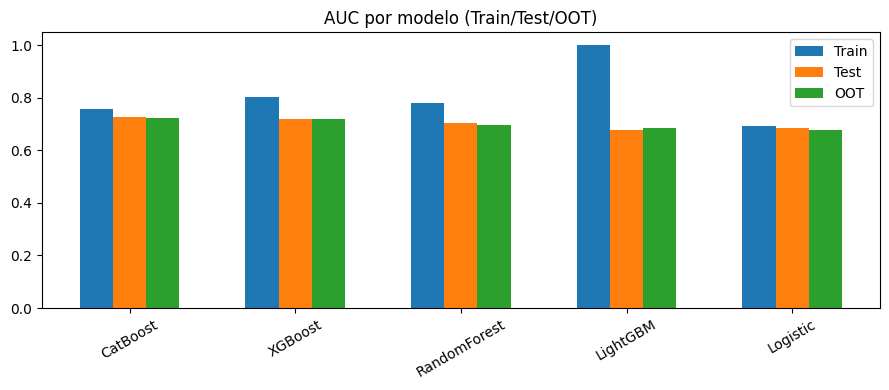

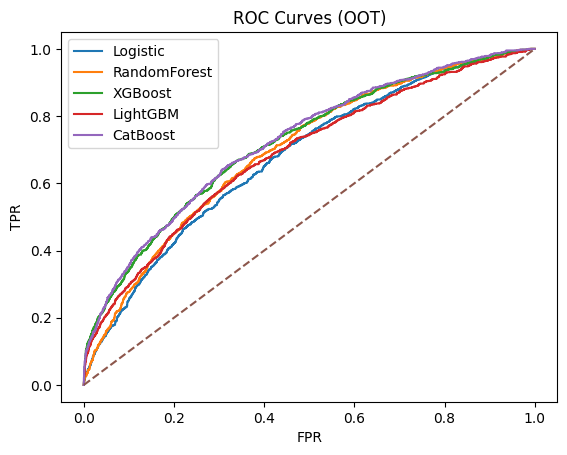

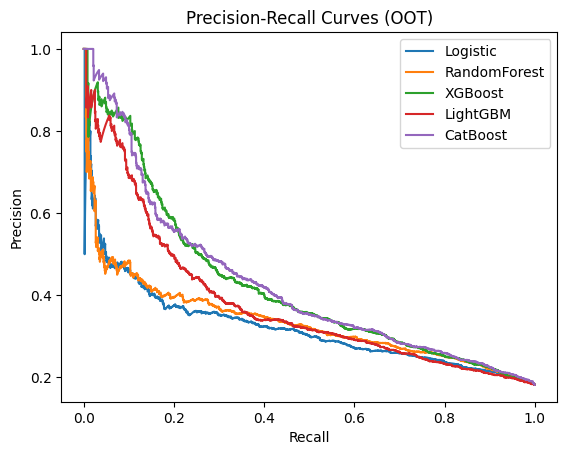

In [20]:
# A) Barras AUC
plt.figure(figsize=(9,4))
x = np.arange(len(results_df))
plt.bar(x-0.2, results_df["Train_AUC"], width=0.2, label="Train")
plt.bar(x,      results_df["Test_AUC"],  width=0.2, label="Test")
plt.bar(x+0.2,  results_df["OOT_AUC"],   width=0.2, label="OOT")
plt.xticks(x, results_df["Model"], rotation=30)
plt.title("AUC por modelo (Train/Test/OOT)")
plt.legend()
plt.tight_layout()
plt.show()

# B) ROC OOT
plt.figure()
for name, pr in preds_map.items():
    fpr, tpr, _ = roc_curve(y_oot, pr["p_oot"])
    plt.plot(fpr, tpr, label=name)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("ROC Curves (OOT)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

# C) PR Curve OOT
plt.figure()
for name, pr in preds_map.items():
    prec, rec, _ = precision_recall_curve(y_oot, pr["p_oot"])
    plt.plot(rec, prec, label=name)
plt.title("Precision-Recall Curves (OOT)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.legend()
plt.show()


## 15. Lift / Gains (OOT)
Mostramos **cumulative gain** para comparar capacidad de captura de morosos en el top de score.


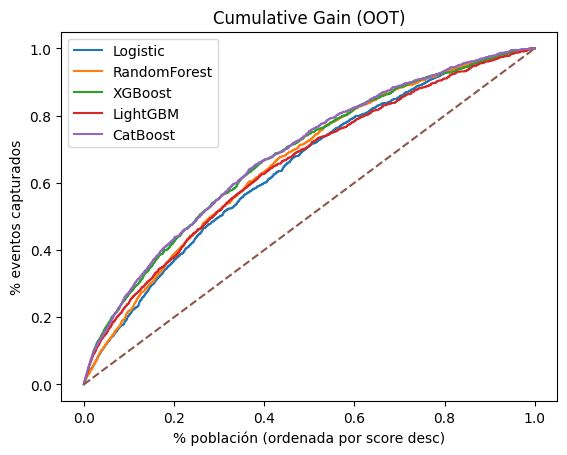

In [21]:
def cumulative_gain(y_true, y_prob):
    tmp = pd.DataFrame({"y": y_true, "p": y_prob}).sort_values("p", ascending=False).reset_index(drop=True)
    tmp["cum_events"] = tmp["y"].cumsum()
    tmp["cum_event_rate"] = tmp["cum_events"] / max(tmp["y"].sum(), 1)
    tmp["pop_rate"] = (np.arange(len(tmp)) + 1) / len(tmp)
    return tmp["pop_rate"].values, tmp["cum_event_rate"].values

plt.figure()
for name, pr in preds_map.items():
    x_pop, y_gain = cumulative_gain(y_oot.values, pr["p_oot"])
    plt.plot(x_pop, y_gain, label=name)
plt.plot([0,1],[0,1], linestyle="--")
plt.title("Cumulative Gain (OOT)")
plt.xlabel("% población (ordenada por score desc)")
plt.ylabel("% eventos capturados")
plt.legend()
plt.show()


## 16. PSI del score (TRAIN vs OOT)
PSI del score es un control central en monitoreo de modelos.


In [22]:
# PSI del score por modelo
psi_score_rows = []
for name, pr in preds_map.items():
    psi_s = psi_numeric(pr["p_train"], pr["p_oot"], buckets=10)
    psi_score_rows.append((name, psi_s))

psi_score_df = pd.DataFrame(psi_score_rows, columns=["Model", "PSI_score_train_vs_oot"]).sort_values("PSI_score_train_vs_oot", ascending=False)
display(psi_score_df)


,Model,PSI_score_train_vs_oot
3,LightGBM,0.169042
4,CatBoost,0.002527
2,XGBoost,0.001652
0,Logistic,0.001458
1,RandomForest,0.001095


## 17. Checklist final (producción)
- Revisar features con correlación sospechosa con el target (leakage)
- Variables con PSI alto (drift)
- PSI del score (drift del score)
- Gaps Train-Test / Test-OOT (overfit vs drift)

Recomendación típica:
- Si buscas **estabilidad**: prioriza menor gap + PSI bajo.
- Si buscas **poder predictivo**: prioriza OOT_GINI alto, pero controla overfit.


# Estabilidad temporal del modelo (Monitoreo productivo)

En producción, un modelo de riesgo se monitorea **en el tiempo**, no solo con una métrica global.

En esta sección calculamos:

- **GINI por mes** (para todos los meses del dataset)
- **GINI móvil 3M** (suaviza ruido)
- **Tendencia** (línea de tendencia del GINI)
- **Alertas** (caídas relevantes vs baseline)
- **GINI por segmento** (ej. región / segmento) para detectar degradación localizada

> Nota: Para meses con target de una sola clase (todo 0 o todo 1), el AUC/GINI no se puede calcular; se reporta como `NaN`.


Modelo monitoreado: CatBoost


,periodo_ord,AUC,GINI
0,202310,0.766553,0.533106
1,202311,0.740212,0.480424
2,202312,0.766656,0.533311
3,202401,0.725096,0.450192
4,202402,0.748366,0.496732
5,202403,0.767803,0.535607
6,202404,0.754476,0.508952
7,202405,0.769128,0.538257
8,202406,0.752718,0.505435
9,202407,0.772041,0.544083


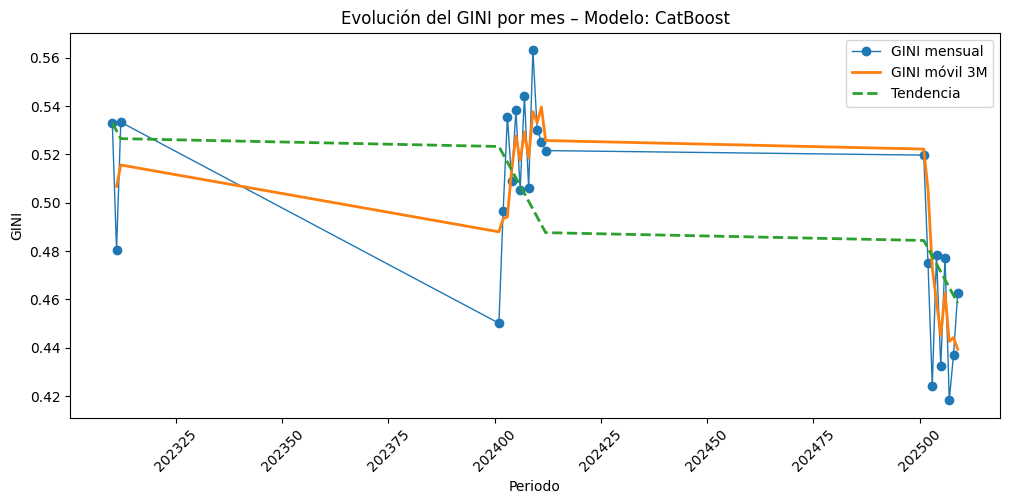

Resumen GINI (mensual):
GINI promedio: 0.4957
Std GINI: 0.0416
Pendiente tendencia (ΔGINI por mes-índice): -0.003239

Alertas:
- ALERTA: caída absoluta de GINI vs baseline >= 0.05 (baseline=0.516, last=0.463).
- ALERTA: caída relativa de GINI vs baseline >= 10% (baseline=0.516, last=0.463).
- ALERTA: GINI móvil 3M cayó >= 0.04 vs baseline (baseline=0.516, MA3_last=0.439).
- ALERTA: tendencia negativa relevante (pendiente=-0.0032).


In [23]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

def gini_from_auc(auc):
    return 2 * auc - 1

def gini_by_month(df_in, score_col, target_col, period_col):
    def _auc_safe(x):
        # AUC requiere 2 clases
        if x[target_col].nunique() < 2:
            return np.nan
        return roc_auc_score(x[target_col], x[score_col])

    out = (
        df_in[[period_col, target_col, score_col]]
        .groupby(period_col, as_index=False)
        .apply(lambda x: _auc_safe(x))
        .rename(columns={None: "AUC"})
    )
    # nb: el groupby+apply puede devolver columna 0 según versión
    if 0 in out.columns and "AUC" not in out.columns:
        out = out.rename(columns={0: "AUC"})
    out["GINI"] = out["AUC"].map(lambda a: gini_from_auc(a) if pd.notnull(a) else np.nan)
    return out.sort_values(period_col).reset_index(drop=True)

def _score_full_dataset(best_model_name):
    # Requiere que ya existan: df, features, preprocess_tree, preprocess_lr, 
    # y modelos entrenados: log_model, rf_model, bst (xgb.train), lgb_clf, cat_clf
    X_full = df[features].copy()

    if best_model_name == "CatBoost":
        # CatBoost: usar el mismo preprocesamiento simple que hicimos para cb (imputación + str)
        X_full_cb = X_full.copy()
        for c in num_cols:
            med = X_train[c].median()
            X_full_cb[c] = pd.to_numeric(X_full_cb[c], errors="coerce").fillna(med)
        for c in cat_cols:
            mode = X_train[c].mode(dropna=True)
            fill = mode.iloc[0] if len(mode) else "MISSING"
            X_full_cb[c] = X_full_cb[c].fillna(fill).astype(str)
        scores = cat_clf.predict_proba(X_full_cb)[:, 1]
        return scores

    if best_model_name == "XGBoost":
        X_full_x = preprocess_tree.transform(X_full)
        dfull = xgb.DMatrix(X_full_x)
        scores = bst.predict(dfull)
        return scores

    if best_model_name == "LightGBM":
        X_full_l = preprocess_tree.transform(X_full)
        scores = lgb_clf.predict_proba(X_full_l)[:, 1]
        return scores

    if best_model_name == "RandomForest":
        scores = rf_model.predict_proba(X_full)[:, 1]
        return scores

    # Logistic (default)
    scores = log_model.predict_proba(X_full)[:, 1]
    return scores

# 1) Selección del modelo a monitorear (top por OOT_GINI)
best_model = results_df.sort_values("OOT_GINI", ascending=False).iloc[0]["Model"]
print("Modelo monitoreado:", best_model)

# 2) Score para TODO el dataset
df = df.copy()
df["score_model"] = _score_full_dataset(best_model)

# 3) GINI mensual
gini_monthly = gini_by_month(df, "score_model", TARGET, "periodo_ord")
display(gini_monthly.head(10))

# 4) GINI móvil 3M
gini_monthly["GINI_MA3"] = gini_monthly["GINI"].rolling(3, min_periods=2).mean()

# 5) Tendencia (regresión lineal simple sobre el índice temporal)
#    (ignoramos NaN)
mask = gini_monthly["GINI"].notna()
x_idx = np.arange(len(gini_monthly))[mask]
y_g = gini_monthly.loc[mask, "GINI"].values
trend = None
if len(x_idx) >= 2:
    b1, b0 = np.polyfit(x_idx, y_g, 1)  # y = b1*x + b0
    trend = (b1, b0)
    gini_monthly["GINI_TREND"] = b1*np.arange(len(gini_monthly)) + b0
else:
    gini_monthly["GINI_TREND"] = np.nan

# 6) Gráfico: GINI por mes + MA3 + tendencia
plt.figure(figsize=(12,5))
plt.plot(gini_monthly["periodo_ord"], gini_monthly["GINI"], marker="o", linewidth=1, label="GINI mensual")
plt.plot(gini_monthly["periodo_ord"], gini_monthly["GINI_MA3"], linewidth=2, label="GINI móvil 3M")
plt.plot(gini_monthly["periodo_ord"], gini_monthly["GINI_TREND"], linestyle="--", linewidth=2, label="Tendencia")
plt.xticks(rotation=45)
plt.title(f"Evolución del GINI por mes – Modelo: {best_model}")
plt.xlabel("Periodo")
plt.ylabel("GINI")
plt.legend()
plt.show()

print("Resumen GINI (mensual):")
print("GINI promedio:", round(gini_monthly["GINI"].mean(skipna=True), 4))
print("Std GINI:", round(gini_monthly["GINI"].std(skipna=True), 4))
if trend is not None:
    print("Pendiente tendencia (ΔGINI por mes-índice):", round(trend[0], 6))

# 7) Alertas simples (configurables)
# Baseline: promedio de los primeros 3 meses calculables
baseline = gini_monthly["GINI"].dropna().head(3).mean() if gini_monthly["GINI"].notna().sum() else np.nan
last = gini_monthly["GINI"].dropna().tail(1).values[0] if gini_monthly["GINI"].notna().sum() else np.nan
last_ma3 = gini_monthly["GINI_MA3"].dropna().tail(1).values[0] if gini_monthly["GINI_MA3"].notna().sum() else np.nan

alerts = []
if pd.notnull(baseline) and pd.notnull(last):
    drop_abs = baseline - last
    drop_rel = drop_abs / max(abs(baseline), 1e-9)
    if drop_abs >= 0.05:
        alerts.append(f"ALERTA: caída absoluta de GINI vs baseline >= 0.05 (baseline={baseline:.3f}, last={last:.3f}).")
    if drop_rel >= 0.10:
        alerts.append(f"ALERTA: caída relativa de GINI vs baseline >= 10% (baseline={baseline:.3f}, last={last:.3f}).")

if pd.notnull(last_ma3) and pd.notnull(baseline):
    if baseline - last_ma3 >= 0.04:
        alerts.append(f"ALERTA: GINI móvil 3M cayó >= 0.04 vs baseline (baseline={baseline:.3f}, MA3_last={last_ma3:.3f}).")

if trend is not None and trend[0] < -0.002:
    alerts.append(f"ALERTA: tendencia negativa relevante (pendiente={trend[0]:.4f}).")

print("\nAlertas:")
if alerts:
    for a in alerts:
        print("-", a)
else:
    print("- Sin alertas (según reglas actuales).")


## GINI por segmento (diagnóstico localizado)

Además del monitoreo global, se recomienda revisar el desempeño **por segmentos** (ej. región, segmento comercial).
Esto ayuda a detectar degradación localizada aunque el promedio global se mantenga.

A continuación calculamos GINI por `region` y por `segmento` para el **último periodo disponible**.


In [24]:

from sklearn.metrics import roc_auc_score

def gini_by_group_last_period(df_in, group_col, score_col="score_model", target_col=TARGET, period_col="periodo_ord", min_n=200):
    last_p = df_in[period_col].max()
    d = df_in[df_in[period_col] == last_p].copy()

    rows = []
    for g, x in d.groupby(group_col):
        n = len(x)
        # AUC requiere 2 clases
        if n < min_n or x[target_col].nunique() < 2:
            rows.append((g, n, np.nan, np.nan))
        else:
            auc = roc_auc_score(x[target_col], x[score_col])
            rows.append((g, n, auc, gini_from_auc(auc)))
    out = pd.DataFrame(rows, columns=[group_col, "n", "AUC", "GINI"]).sort_values("GINI", ascending=False)
    return last_p, out

for gc in ["region", "segmento"]:
    if gc in df.columns:
        last_p, out = gini_by_group_last_period(df, gc, min_n=100)
        print(f"\n--- GINI por {gc} (último periodo={int(last_p)}) ---")
        display(out.head(20))



--- GINI por region (último periodo=202509) ---


,region,n,AUC,GINI
7,Norte,248,0.773232,0.546463
9,Sur,210,0.770707,0.541414
5,Centro,271,0.726502,0.453003
8,Oriente,101,0.718391,0.436782
6,Lima,652,0.704462,0.408924
0,Centro,3,NaN,NaN
1,Lima,7,NaN,NaN
2,Norte,2,NaN,NaN
3,Oriente,1,NaN,NaN
4,Sur,1,NaN,NaN



--- GINI por segmento (último periodo=202509) ---


,segmento,n,AUC,GINI
3,A,358,0.755830,0.511661
5,C,474,0.743707,0.487413
4,B,651,0.719087,0.438173
0,A,3,NaN,NaN
1,B,7,NaN,NaN
2,C,2,NaN,NaN
